In [1]:
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import torch

#Download dos dados de preço das ações Itau Unibanco com ticker "ITUB4"
df_reduced = yf.download('ITUB4.SA', start="2016-01-01", end="2024-03-31")

[*********************100%%**********************]  1 of 1 completed


In [2]:
#Ordenando valores por data
df_reduced = df_reduced.sort_values(by='Date')

#Calculando a mediana entre abertura e fechamento e atribuindo a coluna median
df_reduced['Median'] = df_reduced[['Open','Close']].median(axis=1)

<function matplotlib.pyplot.show(close=None, block=None)>

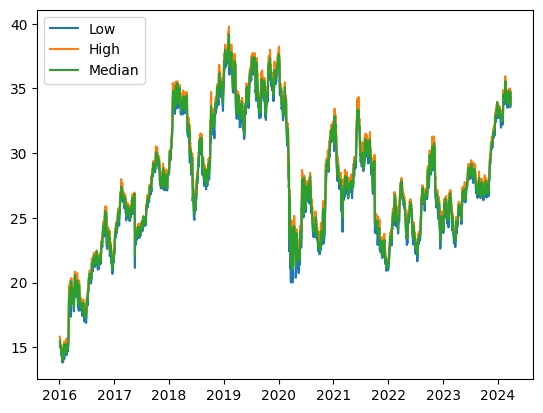

In [3]:
#Gerando gráfico da média de preços da ação
plt.plot(df_reduced['Low'], label = 'Low')
plt.plot(df_reduced['High'], label = 'High')
plt.plot(df_reduced['Median'], label = 'Median')
plt.legend()
plt.show

In [4]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(df_reduced.iloc[:, 6:7])

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = torch.autograd.Variable(torch.Tensor(np.array(x)))
dataY = torch.autograd.Variable(torch.Tensor(np.array(y)))

trainX = torch.autograd.Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = torch.autograd.Variable(torch.Tensor(np.array(y[0:train_size])))

testX = torch.autograd.Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = torch.autograd.Variable(torch.Tensor(np.array(y[train_size:len(y)])))


In [5]:
#Checagem dos resources da máquina a qual irá rodar o modelo LSTM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
# Definição do Modelo LSTM
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = torch.nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size,
            num_layers=num_layers, 
            batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        ula, (h_out, _) = self.lstm(x, (h0, c0))
        h_out = h_out.view((x.size(0), self.hidden_size))
        out = self.fc(h_out)
        return out

In [17]:
# Parâmetros do modelo LSTM
input_size = 1
num_layers = 1
hidden_size = 2
output_size = 1
learning_rate = 0.001    
num_epochs = 2000
training_steps_backpropagation = 60
test_steps_backpropagation = 30

#Inicialização do modelo
lstm = LSTMModel(input_size,hidden_size, num_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

#Train model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    #Obtendo a função loss
    loss = criterion(outputs, trainY)
    loss.backward()

    optimizer.step()
    if epoch % 10 == 0:
        print("Epoca: %d, loss: %1.5f" % (epoch, loss.item()))

Epoca: 0, loss: 0.06343
Epoca: 10, loss: 0.06017
Epoca: 20, loss: 0.05767
Epoca: 30, loss: 0.05584
Epoca: 40, loss: 0.05444
Epoca: 50, loss: 0.05331
Epoca: 60, loss: 0.05233
Epoca: 70, loss: 0.05146
Epoca: 80, loss: 0.05067
Epoca: 90, loss: 0.04993
Epoca: 100, loss: 0.04922
Epoca: 110, loss: 0.04853
Epoca: 120, loss: 0.04784
Epoca: 130, loss: 0.04714
Epoca: 140, loss: 0.04643
Epoca: 150, loss: 0.04567
Epoca: 160, loss: 0.04488
Epoca: 170, loss: 0.04402
Epoca: 180, loss: 0.04310
Epoca: 190, loss: 0.04209
Epoca: 200, loss: 0.04098
Epoca: 210, loss: 0.03977
Epoca: 220, loss: 0.03844
Epoca: 230, loss: 0.03698
Epoca: 240, loss: 0.03537
Epoca: 250, loss: 0.03362
Epoca: 260, loss: 0.03170
Epoca: 270, loss: 0.02962
Epoca: 280, loss: 0.02738
Epoca: 290, loss: 0.02498
Epoca: 300, loss: 0.02244
Epoca: 310, loss: 0.01978
Epoca: 320, loss: 0.01706
Epoca: 330, loss: 0.01433
Epoca: 340, loss: 0.01166
Epoca: 350, loss: 0.00915
Epoca: 360, loss: 0.00690
Epoca: 370, loss: 0.00499
Epoca: 380, loss: 0.003

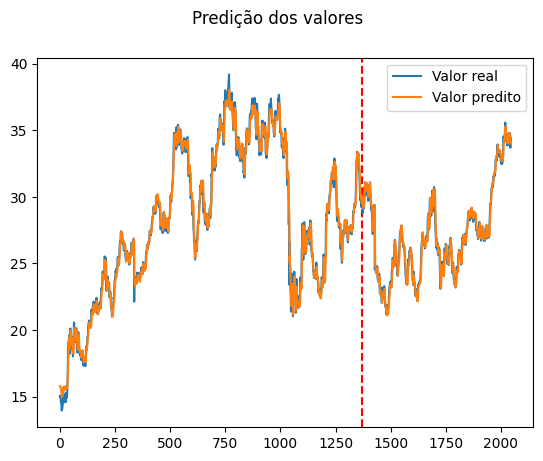

In [18]:
lstm.eval()
train_predict = lstm(dataX)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, label="Valor real")
plt.plot(data_predict, label="Valor predito")
plt.suptitle('Predição dos valores')
plt.legend()
plt.show()